In [1]:
import os
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
PATH = '/home/kai/data/kaggle/homecredit/'

In [2]:
print(os.listdir(PATH + 'submission'))

['06_29_0.csv', '06_25_2.csv', '06_28_pred1.csv', '06_29_0.pkl', '06_26_1.csv', '06_28_pred2.csv', '80_large.pkl', 'blend1.csv', '80_large.csv', '.ipynb_checkpoints']


In [24]:
train_ori = pd.read_pickle(PATH + 'train_bo0.pkl')
test_ori = pd.read_pickle(PATH + 'test_bo0.pkl')


# Train features test

In [ ]:
'''1. Try out some categorical train features to extract some features
DAYS_BIRTH
NAME_EDUCATION_TYPE
NAME_INCOME_TYPE
DAYS_EMPLOYED
2. Some ext tryout
3. Some prev and curr tryout
'''

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
ext_list = [col for col in train_ori.columns if 'EXT' in col]
ext_list

['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

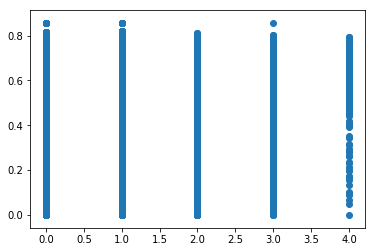

In [30]:
plt.scatter(train_ori.NAME_EDUCATION_TYPE, train_ori.EXT_SOURCE_2)

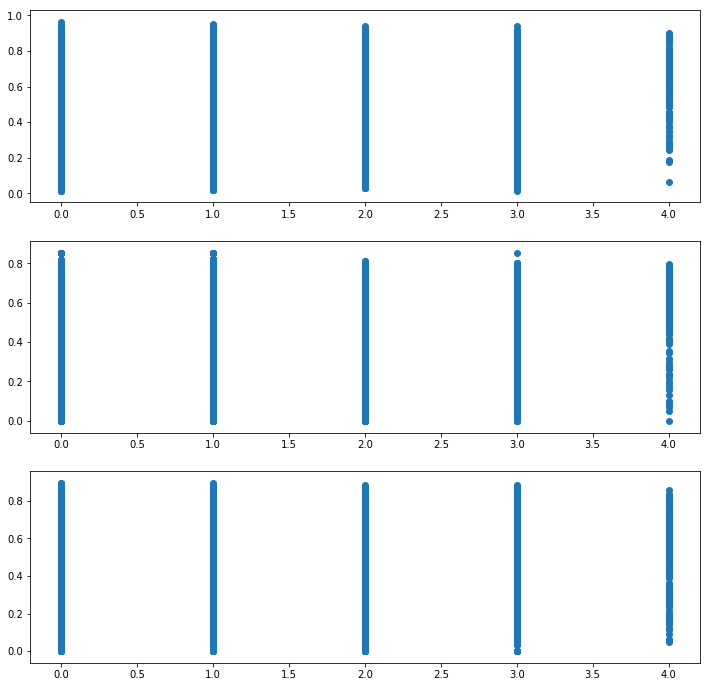

In [33]:
plt.figure(figsize = (12,12))
for i, ext in enumerate(ext_list):
    plt.subplot(3, 1, i + 1)
    plt.scatter(train_ori.NAME_EDUCATION_TYPE, train_ori[ext])

In [34]:
# ext tryout
ext_train  = train_ori[ext_list]
ext_train.describe()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
count,134133.000000,3.068510e+05,246546.000000
mean,0.502130,5.143927e-01,0.510853
std,0.211062,1.910602e-01,0.194844
min,0.014568,8.173617e-08,0.000527
25%,0.334007,3.924574e-01,0.370650
50%,0.505998,5.659614e-01,0.535276
75%,0.675053,6.636171e-01,0.669057
max,0.962693,8.549997e-01,0.896010


In [35]:
examine_list = ['DAYS_BIRTH','NAME_EDUCATION_TYPE','NAME_INCOME_TYPE','DAYS_EMPLOYED']

In [36]:
train_test = train_ori[examine_list + ext_list]

In [37]:
train_test.head()

,DAYS_BIRTH,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE,DAYS_EMPLOYED,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,-9461,0,0,-637,0.083037,0.262949,0.139376
1,-16765,1,1,-1188,0.311267,0.622246,NaN
2,-19046,0,0,-225,NaN,0.555912,0.729567
3,-19005,0,0,-3039,NaN,0.650442,NaN
4,-19932,0,0,-3038,NaN,0.322738,NaN


In [40]:
train_test.corr(method = 'spearman')

,DAYS_BIRTH,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE,DAYS_EMPLOYED,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
DAYS_BIRTH,1.000000,0.165168,-0.434971,-0.222606,-0.600176,-0.102158,-0.205208
NAME_EDUCATION_TYPE,0.165168,1.000000,0.011242,-0.044485,0.075638,0.103026,-0.042517
NAME_INCOME_TYPE,-0.434971,0.011242,1.000000,0.487801,0.231165,0.056645,0.089174
DAYS_EMPLOYED,-0.222606,-0.044485,0.487801,1.000000,-0.034282,-0.084061,-0.013565
EXT_SOURCE_1,-0.600176,0.075638,0.231165,-0.034282,1.000000,0.220776,0.181127
EXT_SOURCE_2,-0.102158,0.103026,0.056645,-0.084061,0.220776,1.000000,0.106182
EXT_SOURCE_3,-0.205208,-0.042517,0.089174,-0.013565,0.181127,0.106182,1.000000


In [41]:
# ext_1
ext_1_list = ['oneoverext_1', 'double_1','oneminusext_1','triple_1']
train_test['oneoverext_1'] = 1/train_test['EXT_SOURCE_1']
train_test['double_1'] = train_test['EXT_SOURCE_1'] ** 2
train_test['triple_1'] = train_test['EXT_SOURCE_1'] ** 3
train_test['oneminusext_1'] = 1 - train_test['EXT_SOURCE_1']

/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [42]:
train_1 = train_test[ext_1_list + examine_list]
train_1.corr(method = 'spearman')

,oneoverext_1,double_1,oneminusext_1,triple_1,DAYS_BIRTH,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE,DAYS_EMPLOYED
oneoverext_1,1.000000,-1.000000,1.000000,-1.000000,0.600176,-0.075638,-0.231165,0.034282
double_1,-1.000000,1.000000,-1.000000,1.000000,-0.600176,0.075638,0.231165,-0.034282
oneminusext_1,1.000000,-1.000000,1.000000,-1.000000,0.600176,-0.075638,-0.231165,0.034282
triple_1,-1.000000,1.000000,-1.000000,1.000000,-0.600176,0.075638,0.231165,-0.034282
DAYS_BIRTH,0.600176,-0.600176,0.600176,-0.600176,1.000000,0.165168,-0.434971,-0.222606
NAME_EDUCATION_TYPE,-0.075638,0.075638,-0.075638,0.075638,0.165168,1.000000,0.011242,-0.044485
NAME_INCOME_TYPE,-0.231165,0.231165,-0.231165,0.231165,-0.434971,0.011242,1.000000,0.487801
DAYS_EMPLOYED,0.034282,-0.034282,0.034282,-0.034282,-0.222606,-0.044485,0.487801,1.000000


In [1]:
import os
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
PATH = '/home/kai/data/kaggle/homecredit/'

pred_803 = pd.read_csv(PATH + 'submission/blend1.csv')
pred_800 = pd.read_csv(PATH + 'submission/06_29_0.csv')
pred_2 = pd.read_csv(PATH +'test_2/pred_2.csv')
pred_3 = pd.read_csv(PATH +'test_2/pred_3.csv')

In [2]:
# change 803 < 0.005 to zero
# change 800 > 0.5 to 0.5
x = pred_803.TARGET < 0.005
y = pred_803.TARGET > 0.5
z = pred_800.TARGET > 0.5

In [3]:
print(x.sum(),y.sum(), z.sum())

313 316 191


In [11]:
t = pred_3.TARGET > 0.5
t.sum()
pred_3.loc[t, 'TARGET'] = 1

214

In [8]:
pred_803.loc[x, 'TARGET'] = 0

blend2 = pred_803.copy()
blend2.TARGET = pred_803.TARGET * 0.8 + pred_800.TARGET* 0.05 + pred_3.TARGET * 0.15

In [10]:
(blend2.TARGET >0.5).sum()
blend2.to_csv(PATH + 'submission/blend2.csv', index = False)

In [14]:
(blend2.TARGET > 0.5).sum()

275

In [12]:
t = pred_3.TARGET > 0.5
t.sum()
pred_3.loc[t, 'TARGET'] = 1
blend3 = pred_803.copy()
blend3.TARGET = pred_803.TARGET * 0.8 + pred_3.TARGET * 0.2

In [13]:
(blend3.TARGET >0.5).sum()

302

In [15]:
blend3.to_csv(PATH + 'submission/blend3.csv', index = False)